In [ ]:
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

# Lazy imports so pylint compains, therefore we disable it
from tensorflow.keras.utils import to_categorical  # type: ignore
from tensorflow.keras import models, layers, optimizers  # type: ignore
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
import re
import os

In [3]:
# If Google Colab
is_colab_used = False
folder_path = "./data/full-dataset/train/clean"
if is_colab_used:
    from google.colab import drive  # type: ignore

    drive.mount("/content/drive")
    folder_path = "/content/drive/My Drive/CS4243/"

# 1. Collect All Raw Data

In [4]:
file_list = os.listdir(folder_path)
df = pd.DataFrame(file_list, columns=["file_name"])
df["original_file_path"] = df["file_name"].apply(lambda x: os.path.join(folder_path, x))
df["label"] = df["file_name"].str.split("-0").str[0]

print(f"Number of unique images: {len(df['label'].unique())}")

# # Debug - Get subset of dataframe
# df = df[0:100]

Number of unique images: 7744


# 2. Pre-process Data for Training the Model

In [5]:
def replace_black_with_surrounding_color_optimized(img):
    result = img.copy()

    height, width, _ = img.shape

    # Create a mask where black pixels are True (shape: (height, width))
    black_mask = np.all(img == [0, 0, 0], axis=-1)

    # Initialize an array to accumulate the surrounding pixel values
    accumulator = np.zeros_like(img, dtype=np.float32)

    # Initialize a count of surrounding non-black pixels for each black pixel
    surrounding_count = np.zeros((height, width), dtype=np.float32)

    # Loop through the 8 surrounding pixels (dy, dx in {-1, 0, 1}, skipping (0, 0))
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue  # Skip the black pixel itself

            # Roll the image to get the surrounding pixels
            rolled_img = np.roll(np.roll(img, shift=dy, axis=0), shift=dx, axis=1)

            # Create a mask of the surrounding non-black pixels
            non_black_mask = np.all(rolled_img != [0, 0, 0], axis=-1)

            # Only accumulate colors from non-black pixels
            accumulator += rolled_img * non_black_mask[..., np.newaxis]

            # Update the surrounding count for non-black pixels
            surrounding_count += non_black_mask

    # Avoid division by zero: replace zeros in surrounding_count with 1 to prevent errors
    surrounding_count[surrounding_count == 0] = 1

    # For black pixels, replace them with the average color of surrounding pixels
    result[black_mask] = (
        accumulator[black_mask] / surrounding_count[black_mask, np.newaxis]
    ).astype(np.uint8)

    return result


def process_image(image_path, output_folder):
    # Load the image using OpenCV
    img = cv2.imread(image_path)

    if img is not None:
        # Apply the optimized function to clean the image
        cleaned_image = replace_black_with_surrounding_color_optimized(img)

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Construct the new file path (same filename, different folder)
        output_path = os.path.join(output_folder, os.path.basename(image_path))

        # Save the cleaned image to the new folder
        cv2.imwrite(output_path, cleaned_image)

        return output_path
    else:
        print(f"Error: Could not load image at {image_path}")
        return None


def process_images(image_paths, output_folder):
    results = []
    for path in tqdm(image_paths):
        results.append(process_image(path, output_folder))
    return results


output_folder = os.path.join("./data", "cleaned_images")
df["processed_images"] = process_images(
    df["original_file_path"].tolist(), output_folder
)

100%|██████████| 7744/7744 [00:46<00:00, 167.02it/s]


# 3. Augment Images for Training Variation

In [6]:
# # Take Processed Images, augment 40% of the images
# df_augment = df.sample(frac=0.4, random_state=42)

# # Remove augmented images from original dataframe
# print("Original DF size before augmentation:", len(df["processed_images"]))
# df = df.drop(df_augment.index)

# IMG_HEIGHT = 400
# IMG_WIDTH = 80
# BATCH_SIZE = 32


# # Function to load and resize images
# def load_image(file_path):
#     img = tf.io.read_file(file_path)
#     img = tf.image.decode_png(img, channels=3)
#     img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
#     return img

# # Create a TensorFlow dataset from the file paths
# augment_ds = tf.data.Dataset.from_tensor_slices(df_augment["processed_images"].tolist())

# # Load and preprocess the images
# augment_ds = augment_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# # Filter out any None images (those that failed to load)
# augment_ds = augment_ds.filter(lambda x: x is not None)

# augment_layers = Sequential(
#     [
#         layers.Rescaling(1.0 / 255),  # Normalize the images to [0, 1]
#         layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0]),
#         layers.RandomContrast(factor=0.3),
#         layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#         layers.RandomZoom(height_factor=0.2, width_factor=0.1, fill_mode="nearest"),
#         layers.RandomRotation(factor=0.02, fill_mode="nearest"),
#     ]
# )

# # Apply the augmentation layers to the dataset
# augment_ds = augment_ds.map(lambda x: augment_layers(x), num_parallel_calls=tf.data.AUTOTUNE)

# # Convert back to DF
# augmented_images = []
# for batch in augment_ds:
#     for img in batch:
#         augmented_images.append(img.numpy())

# df_augmented = pd.DataFrame(
#     {"processed_images": augmented_images, "is_augmented": True}
# )

# # Modify the original dataframe to include the augmented images
# df["is_augmented"] = False

# # Merge the two dataframes
# df = pd.concat([df, df_augmented], ignore_index=True)
# print(df.head())
# print("New DF size after augmentation:", len(df["processed_images"]))

# # Uncomment to see examples:
# # def show_images(dataset, augmentation_layer, num_images=5):
# #     plt.figure(figsize=(10, 10))
# #     for images in dataset.take(1):
# #         augmented_images = augmentation_layer(images)
# #         augmented_images = tf.clip_by_value(augmented_images, 0.0, 1.0)
# #         for i in range(num_images):
# #             _ = plt.subplot(1, num_images, i + 1)
# #             plt.imshow(augmented_images[i].numpy())
# #             plt.axis("off")
# #     plt.show()
# # show_images(train_ds, augment_layers, 3)

# 4. Format Data for Training the Model

100%|██████████| 7744/7744 [00:04<00:00, 1644.22it/s]


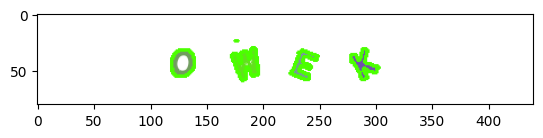

In [7]:
# Function to process images and extract ROIs
output_char_folder = os.path.join("./data", "extracted_chars")
if not os.path.exists(output_char_folder):
    os.makedirs(output_char_folder)
contour_too_small_threshold = 8


def extract_rois(image_path):
    # Load the processed image
    img = cv2.imread(image_path)

    if img is not None:
        # Convert to grayscale and threshold
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)

        # Find contours
        contours, _ = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        img_with_contours = img.copy()
        cv2.drawContours(img_with_contours, contours, -1, (0, 255, 75), 2)

        plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))

        # Sort contours from left to right
        sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

        rois = []  # List to store ROIs for display later
        for contour in sorted_contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w <= contour_too_small_threshold and h <= contour_too_small_threshold:
                continue

            # Draw bounding box on the image (optional)
            cv2.rectangle(img_with_contours, (x, y), (x + w, y + h), (36, 255, 12), 2)

            # Extract ROI and store it TESTINGGGGGG
            ROI = img[y : y + h, x : x + w]

            # Padding and resizing
            if w > h:
                # Add padding to the top and bottom
                pad_top = (w - h) // 2
                pad_bottom = w - h - pad_top
                ROI_padded = cv2.copyMakeBorder(
                    ROI,
                    pad_top,
                    pad_bottom,
                    0,
                    0,
                    cv2.BORDER_CONSTANT,
                    value=(255, 255, 255),
                )
            else:
                # Add padding to the left and right
                pad_left = (h - w) // 2
                pad_right = h - w - pad_left
                ROI_padded = cv2.copyMakeBorder(
                    ROI,
                    0,
                    0,
                    pad_left,
                    pad_right,
                    cv2.BORDER_CONSTANT,
                    value=(255, 255, 255),
                )

            resized_ROI = cv2.resize(ROI_padded, (32, 32))
            rois.append(resized_ROI)

        return img_with_contours, rois  # Return both the image with contours and ROIs
    else:
        print(f"Error: Could not load image at {image_path}")
        return None, []


# Apply the ROI extraction to processed images in the DataFrame
df["rois"] = df["processed_images"].progress_apply(lambda path: extract_rois(path))

# # Debug - Display results
# for index, (contours_image, rois) in enumerate(
#     zip(df["rois"].apply(lambda x: x[0]), df["rois"].apply(lambda x: x[1]))
# ):
    # plt.figure(figsize=(10, 5))

    # # Display image with bounding boxes
    # plt.subplot(1, 2, 1)
    # plt.imshow(cv2.cvtColor(contours_image, cv2.COLOR_BGR2RGB))
    # plt.title("Image with Contours")
    # plt.axis("off")

    # Display ROIs
    # plt.subplot(1, 2, 2)
    # for i, roi in enumerate(rois):
    #     plt.subplot(1, len(rois), i + 1)
    #     plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    #     plt.title(f"CHAR {i + 1}")
    #     plt.axis("off")
    # plt.show()
    # break

-----POTENTIAL MISMATCH-----
Mismatch for ./data/cleaned_images/y0cq-0.png: 2 ROIs but label length is 4.
Mismatch for ./data/cleaned_images/9a2xdo-0.png: 8 ROIs but label length is 6.
Mismatch for ./data/cleaned_images/g0o1-0.png: 5 ROIs but label length is 4.
Mismatch for ./data/cleaned_images/wg3pj3rn-0.png: 7 ROIs but label length is 8.
Mismatch for ./data/cleaned_images/tm364-0.png: 4 ROIs but label length is 5.
Mismatch for ./data/cleaned_images/mg1po-0.png: 3 ROIs but label length is 5.
Mismatch for ./data/cleaned_images/v8li-0.png: 3 ROIs but label length is 4.
Mismatch for ./data/cleaned_images/s7wqfx5-0.png: 9 ROIs but label length is 7.
Mismatch for ./data/cleaned_images/q8a8rf5u-0.png: 9 ROIs but label length is 8.
Mismatch for ./data/cleaned_images/m6vljgf-0.png: 8 ROIs but label length is 7.
Mismatch for ./data/cleaned_images/mf1a02-0.png: 5 ROIs but label length is 6.
Mismatch for ./data/cleaned_images/gi00g-0.png: 7 ROIs but label length is 5.
Mismatch for ./data/cleane

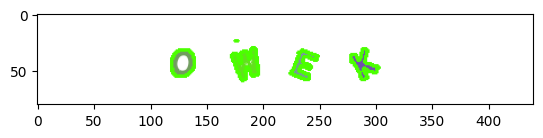

In [8]:
# Create a directory for saving character images if it doesn't exist
output_char_folder = os.path.join("./data", "extracted_chars")
if not os.path.exists(output_char_folder):
    os.makedirs(output_char_folder)

mismatch_count = 0
mismatched_images = []  # To store mismatched images for display



# Function to save ROIs if the count matches the label length
def save_rois_if_match(image_path, label, rois):
    global mismatch_count  # Declare mismatch_count as global
    # Check if number of ROIs matches the length of the label
    if len(rois) == len(label):
        saved_paths = []
        for i, roi in enumerate(rois):
            # Construct the file name and save the ROI
            roi_file_name = f"{os.path.basename(image_path).split('.')[0]}_char_{i + 1}.png"
            roi_path = os.path.join(output_char_folder, roi_file_name)
            cv2.imwrite(roi_path, roi)
            saved_paths.append(roi_path)
        return saved_paths
    else:
        print(f"Mismatch for {image_path}: {len(rois)} ROIs but label length is {len(label)}.")
        mismatch_count += 1
        mismatched_images.append((image_path, rois))
        return []

# Creating a new DataFrame to store saved image paths
saved_images_data = []

# Iterate through the DataFrame to process each image
print('-----POTENTIAL MISMATCH-----')
for idx, row in df.iterrows():
    image_path = row['processed_images']
    label = row['label']  # Assuming you have a 'label' column in the DataFrame
    contours_image, rois = extract_rois(image_path)

    # Save ROIs if they match the label length
    saved_paths = save_rois_if_match(image_path, label, rois)

    # Append the results to the new DataFrame
    if saved_paths:
        saved_images_data.append({
            'image_path': image_path,
            'label': label,
            'saved_char_paths': saved_paths
        })

print(f'TOTAL MISMATCH COUNT: {mismatch_count}')

# 5. Cleaned Data Collection For Training


len(X):  41147
len(y):  41147
Sample image:


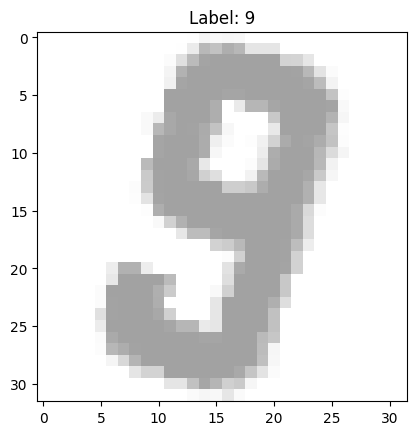

In [9]:
X = []
Y = []

folder_path = "./data/extracted_chars"
file_list = os.listdir(folder_path)
df = pd.DataFrame(file_list, columns=["file_name"])
df["original_file_path"] = df["file_name"].apply(lambda x: os.path.join(folder_path, x))
df["label"] = df["file_name"].apply(lambda x: x.split("-0")[-1].split(".png")[0])

for filename in os.listdir(folder_path):
    re_match = re.search(r"(\d+)(?=\.png)", filename)
    if not re_match:
        print(f"Could not read {filename}, skipping")
        continue

    digit = int(re_match.group(1))
    if digit != 0 or not is_colab_used:
        file_path = os.path.join(folder_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            # Resize the image to 32x32 pixels
            resized_image = cv2.resize(image, (32, 32))
            X.append(resized_image)
            Y.append(filename[digit - 1])
        else:
            print(f"Could not read {filename} from {file_path}, skipping")

print("len(X): ", len(X))
print("len(y): ", len(Y))
print("Sample image:")
rand_idx = np.random.randint(0, len(X))
plt.imshow(cv2.cvtColor(X[rand_idx], cv2.COLOR_BGR2RGB))
plt.title(f"Label: {Y[rand_idx]}")

X = np.array(X)
Y = np.array(Y)

# 6. Preparing Processed Data for Training

In [10]:
digits = [str(i) for i in range(10)]
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]
char_list = digits + letters


# Normalize
def normalize_data(data):
    return data / 255.0


# One hot encoding
def one_hot_encode_labels(labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    encoded = label_encoder.transform(labels)
    categorical = to_categorical(encoded, num_classes=len(char_list))

    return categorical


X = normalize_data(X)
Y = one_hot_encode_labels(Y)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# 7. Building Model


In [11]:
# Build Model Function
def build_model(learning_rate=0.01, dropout_rate=0.5):
    model = models.Sequential()
    model.add(
        layers.Conv2D(
            filters=32, kernel_size=(3, 3), activation="relu", input_shape=(32, 32, 1)
        )
    )
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(36, activation="softmax"))  # 0-9, a-z

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Train Model Function
def train_model(X, y):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    y_encoded = label_encoder.transform(y)
    y_categorical = to_categorical(y_encoded, num_classes=36)

    model = build_model(input_shape=X.shape[1:])  # Using input shape from X
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.fit(X, y_categorical, epochs=10, batch_size=32)

    return model, label_encoder


# Predict Function
def predict_model(model, label_encoder, X):
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = label_encoder.inverse_transform(predicted_classes)
    return predicted_labels

# 8. Cross Validation


In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_accuracy = []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = build_model()

    model.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=64,
    )

    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    kf_accuracy.append(val_acc)

print(f"Cross-Validation Accuracies: {kf_accuracy}")
print(f"Mean Accuracy: {np.mean(kf_accuracy)}")

Epoch 1/10


/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0496 - loss: 3.6786 - val_accuracy: 0.1848 - val_loss: 3.3116
Epoch 2/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1820 - loss: 2.9289 - val_accuracy: 0.3338 - val_loss: 3.2530
Epoch 3/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2798 - loss: 2.5263 - val_accuracy: 0.4210 - val_loss: 2.3213
Epoch 4/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2986 - loss: 2.4220 - val_accuracy: 0.4118 - val_loss: 2.5466
Epoch 5/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3284 - loss: 2.3310 - val_accuracy: 0.4822 - val_loss: 1.8708
Epoch 6/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3358 - loss: 2.3163 - val_accuracy: 0.4859 - val_loss: 1.9610
Epoch 7/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3604 - loss: 2.2236 - val_accuracy: 0.5202 - val_loss: 1.7657
Epoch 8/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3504 - loss: 2.2561 - val_accuracy: 0.4833 - val_

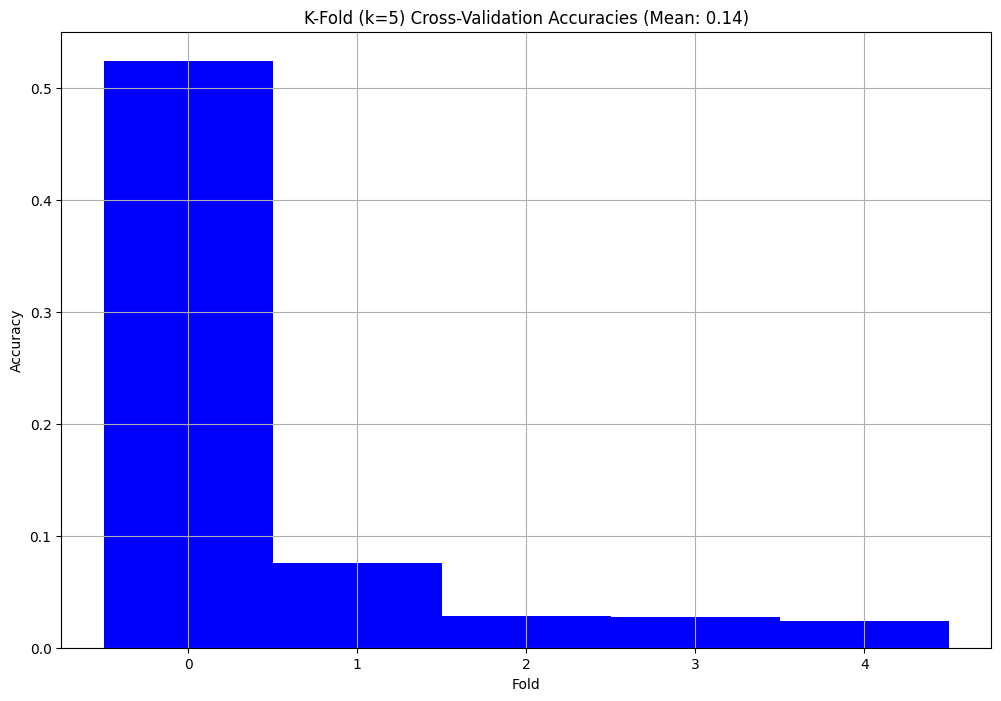

In [13]:
# Plot K-Fold Cross-Validation Accuracies
plt.figure(figsize=(12, 8))
plt.bar(range(len(kf_accuracy)), kf_accuracy, color=(0, 0, 1), width=1.0)

# Configure plot
plt.title(
    f"K-Fold (k=5) Cross-Validation Accuracies (Mean: {np.mean(kf_accuracy):.2f})"
)
plt.xlabel("Fold")
plt.ylabel("Accuracy")
# plt.xticks([])  # Remove x-axis ticks to focus on color distribution
plt.grid()

# Show the plot
plt.show()

# 9. Hyperparameter Tuning


In [46]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(build_fn=build_model, verbose=0)

# Define the grid of hyperparameters
param_grid = {
    "model__learning_rate": [0.001, 0.01, 0.1],
    "model__dropout_rate": [0.0, 0.2, 0.5],
}

# Conduct the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_result.best_params_}")
optimal_learning_rate = grid_result.best_params_["model__learning_rate"]
optimal_dropout_rate = grid_result.best_params_["model__dropout_rate"]

/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vishnusundaresan/Documents/School/CS4243/.v

Best Hyperparameters: {'model__dropout_rate': 0.0, 'model__learning_rate': 0.001}


In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_accuracy = []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = build_model(
        learning_rate=optimal_learning_rate, dropout_rate=optimal_dropout_rate
    )

    model.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=64,
    )

    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    kf_accuracy.append(val_acc)

print(f"Cross-Validation Accuracies: {kf_accuracy}")
print(f"Mean Accuracy: {np.mean(kf_accuracy)}")

Epoch 1/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3781 - loss: 2.3375 - val_accuracy: 0.3955 - val_loss: 2.4159
Epoch 2/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7075 - loss: 1.0280 - val_accuracy: 0.5571 - val_loss: 1.7796
Epoch 3/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7765 - loss: 0.7549 - val_accuracy: 0.6595 - val_loss: 1.2408
Epoch 4/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8216 - loss: 0.5899 - val_accuracy: 0.6125 - val_loss: 1.4768
Epoch 5/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8611 - loss: 0.4637 - val_accuracy: 0.7060 - val_loss: 1.2782
Epoch 6/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8846 - loss: 0.3670 - val_accuracy: 0.7236 - val_loss: 1.1746
Epoch 7/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9003 - loss: 0.3104 - val_accuracy: 0.7154 - val_loss: 1.2672
Epoch 8/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9147 - loss: 0.2713 - val_accuracy: 0.

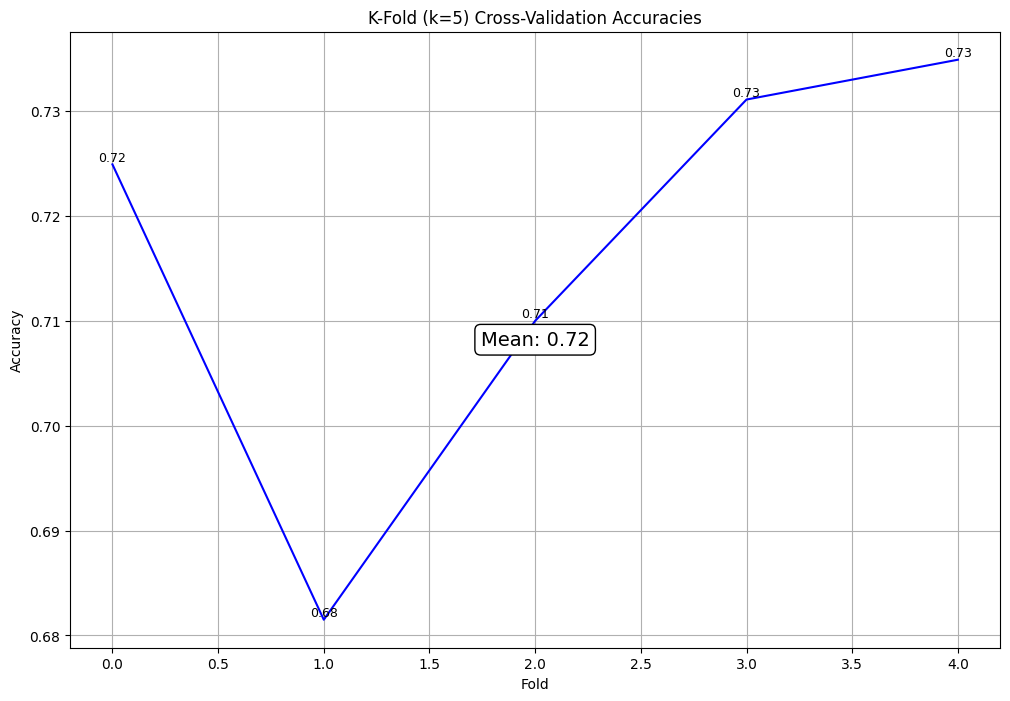

In [50]:
# Plot K-Fold Cross-Validation Accuracies
plt.figure(figsize=(12, 8))
plt.plot(range(len(kf_accuracy)), kf_accuracy, color=(0, 0, 1))
plt.annotate(
    f"Mean: {np.mean(kf_accuracy):.2f}",
    xy=(0.5, 0.5),
    xycoords="axes fraction",
    ha="center",
    va="center",
    fontsize=14,
    bbox=dict(boxstyle="round", fc="w", ec="k"),
)
for a in range(len(kf_accuracy)):
    plt.text(
        a,
        kf_accuracy[a],
        f"{kf_accuracy[a]:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="black",
    )

# Configure plot
plt.title(
    f"K-Fold (k=5) Cross-Validation Accuracies"
)
plt.xlabel("Fold")
plt.ylabel("Accuracy")
# plt.xticks([])  # Remove x-axis ticks to focus on color distribution
plt.grid()

# Show the plot
plt.show()

# 10. Build and Save the Model

In [52]:
# Save the model
from datetime import datetime
from zoneinfo import ZoneInfo

model = build_model(
    learning_rate=optimal_learning_rate, dropout_rate=optimal_dropout_rate
)

# Graph training
log_dir = "logs/fit/" + datetime.now(tz=ZoneInfo("UTC")).strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(  # type: ignore
    log_dir=log_dir, histogram_freq=1
)


model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    callbacks=[tensorboard_callback],
)


model_name = f"model-{datetime.now(tz=ZoneInfo('UTC'))}.keras"
model.save(model_name)

/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4295 - loss: 2.1575
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7220 - loss: 0.9718
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7925 - loss: 0.6973
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8284 - loss: 0.5553
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8568 - loss: 0.4593
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8816 - loss: 0.3776
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8945 - loss: 0.3300
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9064 - loss: 0.2899
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9120 - loss: 0.2633
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9183 - loss: 0.2450
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9274 - loss: 0.2161
Epoch 12/100
515/515 ━━━━━━━━━━━━━━━━━━━━

In [56]:
# # Visualize Tensorboard
%load_ext tensorboard
%tensorboard --logdir {tensorboard_callback.log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 58117), started 0:00:23 ago. (Use '!kill 58117' to kill it.)

# 11. Testing the Model

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'0': {'precision': 0.5813008130081301, 'recall': 0.6271929824561403, 'f1-score': 0.6033755274261603, 'support': 228.0}, '1': {'precision': 0.5946969696969697, 'recall': 0.6680851063829787, 'f1-score': 0.6292585170340681, 'support': 235.0}, '2': {'precision': 0.8009478672985783, 'recall': 0.8666666666666667, 'f1-score': 0.8325123152709359, 'support': 195.0}, '3': {'precision': 0.9, 'recall': 0.9037656903765691, 'f1-score': 0.9018789144050104, 'support': 239.0}, '4': {'precision': 0.8760330578512396, 'recall': 0.8617886178861789, 'f1-score': 0.8688524590163934, 'support': 246.0}, '5': {'precision': 0.859375, 'recall': 0.7568807339449541, 'f1-score': 0.8048780487804879, 'support': 218.0}, '6': {'precision': 0.8085106382978723, 'recall': 0.8016877637130801, 'f1-score': 0.8050847457627118, 'support': 237.0}, '7': {'precision': 0.8391304347826087, 'recall': 0.8894009216589862, 'f1-score': 0.8635346756152126, 'support': 217.0}, '8': {'precision': 0.85

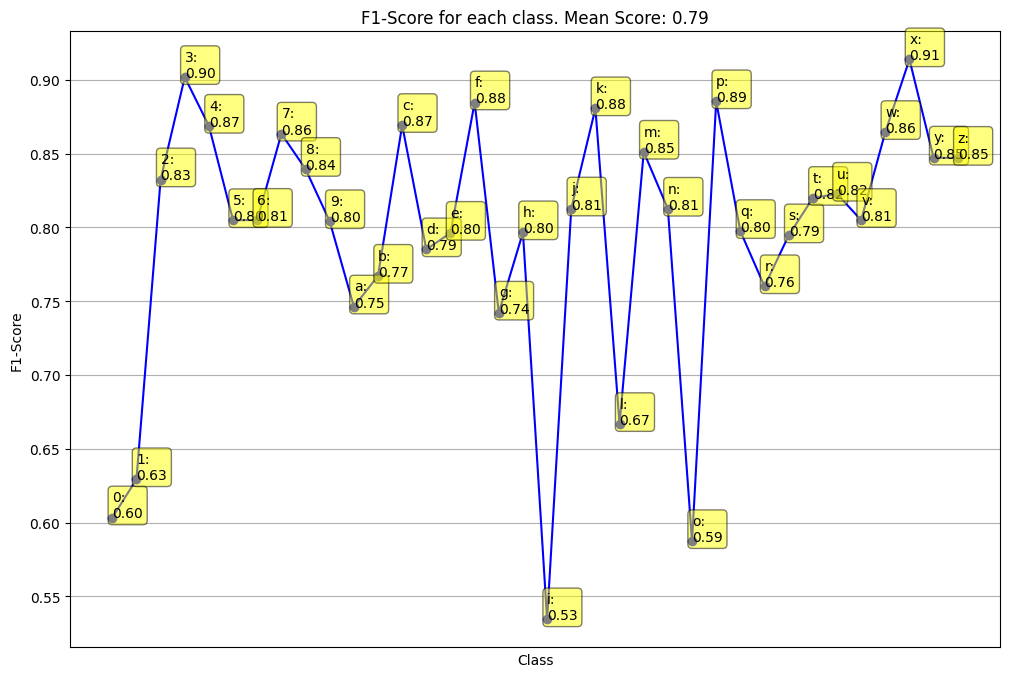

Test Accuracy: 0.794775212636695
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.63      0.60       228
           1       0.59      0.67      0.63       235
           2       0.80      0.87      0.83       195
           3       0.90      0.90      0.90       239
           4       0.88      0.86      0.87       246
           5       0.86      0.76      0.80       218
           6       0.81      0.80      0.81       237
           7       0.84      0.89      0.86       217
           8       0.86      0.82      0.84       216
           9       0.85      0.76      0.80       254
           a       0.75      0.74      0.75       207
           b       0.75      0.79      0.77       255
           c       0.84      0.90      0.87       236
           d       0.78      0.79      0.79       241
           e       0.79      0.80      0.80       215
           f       0.91      0.86      0.88       244
           g       0.74  

In [51]:
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import models


digits = [str(i) for i in range(10)]
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]
char_list = digits + letters

loaded_model = models.load_model("latest.keras")
y_pred = loaded_model.predict(X_test)


def decode_predictions(preds):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)
    decoded_labels = label_encoder.inverse_transform(preds.argmax(axis=1))
    return decoded_labels


y_pred_decoded = decode_predictions(y_pred)
y_test_decoded = decode_predictions(y_test)

accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
num_report = classification_report(y_test_decoded, y_pred_decoded, output_dict=True)

assert type(num_report) == dict

print(num_report)
f1_scores = [num_report[label]["f1-score"] for label in char_list]
# Plot Graph using num_report
plt.figure(figsize=(12, 8))
plt.plot(char_list, f1_scores, marker="o", color="b", label="F1-Score")
# Plot each dot with class name label
for i, txt in enumerate(char_list):
    plt.annotate(
        f"{txt}:\n{f1_scores[i]:.2f}",
        (i, f1_scores[i]),
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1, alpha=0.5),
    )
plt.title(f"F1-Score for each class. Mean Score: {accuracy:.2f}")
plt.xlabel("Class")
plt.ylabel("F1-Score")
plt.xticks([])
plt.grid()
plt.show()

report = classification_report(y_test_decoded, y_pred_decoded, output_dict=False)

print(f"Test Accuracy: {accuracy}")
print("Classification Report:")
print(report)